In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tqdm

In [55]:
path = os.path.dirname(os.getcwd())
# data_path = os.path.join(path, 'data','web-Stanford.txt', 'web-Stanford.txt')
# data_path = os.path.join(path, 'data','web-NotreDame.txt', 'web-NotreDame.txt')
data_path = os.path.join(path, 'data','facebook_combined.txt', 'facebook_combined.txt')
data_path

'c:\\Users\\Linyi Zhang\\Desktop\\data_mining\\HW3\\Datamining_HW3\\data\\facebook_combined.txt\\facebook_combined.txt'

web-NotreDame.txt

Nodes	325729

Edges	1497134

Number of triangles	8910005

In [56]:
class edge_reservoir:
    def __init__(self,s_e):
        self.length=s_e
        self.mem=[set() for _ in range(self.length)]
    
    def add(self,edge,t,i):
        if random.random()<=1/t:
            self.mem[i]=edge
            return True
        return False
    

In [57]:
class wedge_reservoir:
    def __init__(self,s_w):
        self.length=s_w
        self.mem=[[frozenset(),frozenset()] for _ in range(self.length)]
        self.isClosed=[False for _ in range(self.length)]
    

In [58]:
def check_close(wedge:[frozenset,frozenset],edge:set):

    same=wedge[0]|wedge[1]
    return same!=None and (wedge[0]-set(same)).issubset(edge) and (wedge[1]-set(same)).issubset(edge)

In [59]:
tot_wedge=0

In [60]:
def update(edge,t,edge_res:edge_reservoir,wedge_res:wedge_reservoir):
    global tot_wedge
    for i in range(wedge_res.length):
        if check_close(wedge_res.mem[i],edge):
            wedge_res.isClosed[i]=True
    flag=False
    for i in range(min(edge_res.length,t)):
        if edge_res.add(edge,t,i):
            flag=True
    if flag:
        N_t=[]
        for ed in edge_res.mem:
            # print(ed,edge)
            if len(ed|edge)==1:
                tot_wedge+=1
                N_t.append([frozenset(ed),frozenset(edge)])
        for i in range(wedge_res.length):
            x=np.random.rand()
            if x<=len(N_t)/(tot_wedge+1e-8):
                w=random.choice(N_t)
                wedge_res.mem[i]=w
                wedge_res.isClosed[i]=False
    

In [61]:
def Streaming_triangles(filename,s_e,s_w):
    global tot_wedge
    edge_res=edge_reservoir(s_e)
    wedge_res=wedge_reservoir(s_w)
    T_t=[]
    with open(filename, 'r') as file:
        # Skip the header lines
        for _ in range(4):
            next(file)
        line_num=0
        
        for line in tqdm.tqdm(file):           
            if line.strip():
                line_num+=1
                edges=line.strip().split()
                edge={int(edges[0]),int(edges[1])}
                update(edge,line_num,edge_res,wedge_res)
                rol=sum(wedge_res.isClosed)/len(wedge_res.isClosed)
                T_t.append(rol*line_num**2/(s_e*(s_e-1))*tot_wedge)
                if tot_wedge!=0:
                    print(tot_wedge)
    plt.plot(T_t)




In [62]:
# Streaming_triangles(data_path,1000,1000)

In [63]:
def reservoir_sampling(filename, sample_size):
    reservoir = []
    with open(filename, 'r') as file:
        # Skip the header lines
        for _ in range(4):
            next(file)
        
        line_number = 0
        for line in file:
            line_number += 1
            if line.strip():  # Check if the line is not empty
                if len(reservoir) < sample_size:
                    reservoir.append(line.strip())
                else:
                    # Generate a random index from 0 to line_number (inclusive)
                    random_index = random.randint(0, line_number)
                    if random_index < sample_size:
                        reservoir[random_index] = line.strip()
    
    return reservoir



In [64]:
filename = data_path
sample_size = 10  # Set your desired sample size here
sample = reservoir_sampling(filename, sample_size)

# Print the sampled edges
print("Sampled edges:")
for edge in sample:
    print(edge)


Sampled edges:
2331 2423
2187 2491
2757 2927
2209 2362
922 946
2083 2433
1035 1529
2940 3220
1300 1514
1972 2472


In [65]:
from collections import defaultdict
from scipy.stats import bernoulli
from functools import reduce



In [66]:
class Triest_base:
    def __init__(self,M):
        assert M>=6
        self.length=M
        # self.sample=[]
        self.sample: set[frozenset[int]] = set()
        self.t=0
        self.tau=0
        self.tauV=defaultdict(int)
        self.neighbours=defaultdict(set)
    
    def insert(self,filename):
        with open(filename, 'r') as file:
        # Skip the header lines
            # for _ in range(4):
            #     next(file)
            
            for line in file:
                # if line.strip():
                    self.t+=1
                    edges=line.split()
                    if edges[0]==edges[1]:
                        continue
                    edge=frozenset({int(edges[0]),int(edges[1])})
                    if self.sample_edge(edge):
                        # self.sample.append(edge)
                        self.sample.add(edge)
                        self.UpdateCounter(list(edge),"+")
        return self.tau * max(1.0 , self.t*(self.t-1)*(self.t-2)/(self.length*(self.length-1)*(self.length-2)))

                    
    
    def sample_edge(self,edge:set):
        if self.t<=self.length:
            return True
        # elif random.random()<=self.length/self.t:
        elif  bernoulli.rvs(p=self.length / self.t):
            # edge=random.choice(self.sample)
            edge=random.choice(list(self.sample))
            self.sample.remove(edge)
            self.UpdateCounter(list(edge),"-")
            return True
        return False
    
    def UpdateCounter(self,edge,opeartion):
        # print("edge",edge)
        u=edge[0]
        v=edge[1]
        intersection: set[int] = reduce(
            lambda a, b: a & b,
            [
                {
                    node
                    for link in self.sample if vertex in link
                    for node in link if node != vertex
                }
                for vertex in edge
            ]
        )
        # print("intersection",list(intersection))
        if opeartion=="+":
            # self.neighbours[u].add(v)
            # self.neighbours[v].add(u)
            # intersection=self.neighbours[u]&self.neighbours[v]

            # print("intersection",intersection)
            for c in intersection:
                self.tau+=1
                self.tauV[c]+=1
                self.tauV[u]+=1
                self.tauV[v]+=1

                # for node in edge:
                #     self.tauV[node] = self.tauV[node] + 1 
        elif opeartion=="-":
            # self.neighbours[u].discard(v)
            # self.neighbours[v].discard(u)
            # if len(self.neighbours[u])==0:
            #     del self.neighbours[u]
            #     return
            # if len(self.neighbours[v])==0:
            #     del self.neighbours[v]
            #     return
            # intersection=self.neighbours[u]&self.neighbours[v]


            # for c in intersection:
            #     self.tau=max(0,self.tau-1)
            #     self.tauV[c]=max(0,self.tauV[c]-1)
            #     self.tauV[u]=max(0,self.tauV[u]-1)
            #     self.tauV[v]=max(0,self.tauV[v]-1) 

            for c in intersection:
                self.tau-=1
                self.tauV[c]-=1
                self.tauV[u]-=1
                self.tauV[v]-=1
                # for node in edge:
                #     self.tauV[node] = self.tauV[node] - 1 



[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


100%|██████████| 10/10 [12:46<00:00, 76.62s/it]


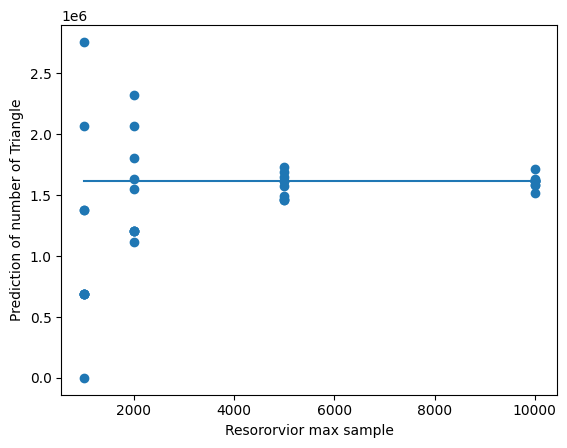

In [67]:
Ms=[1000,2000,5000,10000]
# Ms=[500]
test=10
X=[i for i in Ms for _ in range(test)]
print(X)
Y=[]
for M in Ms:
    for _ in tqdm.tqdm(range(test)):
        algor=Triest_base(M=M)
        
        Y.append(algor.insert(data_path))
plt.scatter(X,Y)
plt.xlabel("Resororvior max sample")
plt.ylabel("Prediction of number of Triangle")
plt.plot([Ms[0], Ms[-1]], [1612010, 1612010])
plt.show()


In [68]:
for i in range(len(X)):
    print("X=",X[i], "Y=",Y[i])


X= 1000 Y= 688964.9176803096
X= 1000 Y= 1377929.8353606192
X= 1000 Y= 688964.9176803096
X= 1000 Y= 1377929.8353606192
X= 1000 Y= 2066894.7530409289
X= 1000 Y= 2755859.6707212385
X= 1000 Y= 688964.9176803096
X= 1000 Y= 688964.9176803096
X= 1000 Y= 0.0
X= 1000 Y= 688964.9176803096
X= 2000 Y= 2321766.967460433
X= 2000 Y= 1117887.799147616
X= 2000 Y= 2063792.8599648294
X= 2000 Y= 1203879.168312817
X= 2000 Y= 1203879.168312817
X= 2000 Y= 1203879.168312817
X= 2000 Y= 1203879.168312817
X= 2000 Y= 1633836.0141388231
X= 2000 Y= 1805818.7524692256
X= 2000 Y= 1547844.644973622
X= 5000 Y= 1468097.861499845
X= 5000 Y= 1649548.15898859
X= 5000 Y= 1578067.738765751
X= 5000 Y= 1462599.3676365498
X= 5000 Y= 1462599.3676365498
X= 5000 Y= 1611058.7019455228
X= 5000 Y= 1688037.616031657
X= 5000 Y= 1611058.7019455228
X= 5000 Y= 1495590.3308163215
X= 5000 Y= 1726527.073074724
X= 10000 Y= 1619507.7077423627
X= 10000 Y= 1582404.009728749
X= 10000 Y= 1614010.8635921977
X= 10000 Y= 1709518.5307013146
X= 10000 Y

In [73]:
class TRIEST_IMPR:
    def __init__(self,M):
        self.length=M
        self.sample=list()
        self.t=-1
        self.tau=0
        self.tauV=defaultdict(int)
        self.neighbours=defaultdict(set)
    
    def insert(self,filename):
        with open(filename, 'r') as file:
        # Skip the header lines
            # for _ in range(4):
            #     next(file)
            
            for line in file:
                if line.strip():
                    self.t+=1
                    edges=line.strip().split()
                    edge=frozenset({int(edges[0]),int(edges[1])})
                    self.UpdateCounter(list(edge))
                    if self.sample_edge(edge,self.t):
                        self.sample.append(edge)
                    
    
    def sample_edge(self,edge:set,t):
        if self.t<=self.length:
            return True
        elif random.random()<=self.length/t:
            edge=random.choice(self.sample)
            self.sample.remove(edge)
            return True
        return False
    
    def UpdateCounter(self,edge):
        u=edge[0]
        v=edge[1]
        intersection: set[int] = reduce(
            lambda a, b: a & b,
            [
                {
                    node
                    for link in self.sample if vertex in link
                    for node in link if node != vertex
                }
                for vertex in edge
            ]
        )
        # self.neighbours[u].add(v)
        # self.neighbours[v].add(u)
        # intersection=self.neighbours[u]&self.neighbours[v]
        eta=max(1,(self.t-1)*(self.t-2)/(self.length*(self.length-1)))
        for c in intersection:
            self.tau+=eta
            self.tauV[c]+=eta
            self.tauV[u]+=eta
            self.tauV[v]+=eta


[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


100%|██████████| 10/10 [10:21<00:00, 62.11s/it]


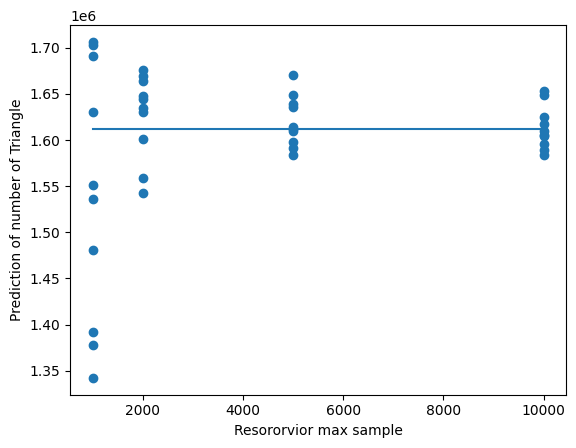

In [74]:
# Ms=[500,1000,2000,5000,10000]
Ms=[1000,2000,5000,10000]
test=10
X=[i for i in Ms for _ in range(test)]
print(X)
Y=[]
for M in Ms:
    for _ in tqdm.tqdm(range(10)):
        algor=TRIEST_IMPR(M=M)
        algor.insert(data_path)
        Y.append(algor.tau)
plt.scatter(X,Y)
plt.xlabel("Resororvior max sample")
plt.ylabel("Prediction of number of Triangle")
plt.plot([Ms[0], Ms[-1]], [1612010, 1612010])
plt.show()

In [75]:
for i in range(len(X)):
    print("X=",X[i], "Y=",Y[i])

X= 1000 Y= 1706221.0181641644
X= 1000 Y= 1391874.9475615618
X= 1000 Y= 1551348.4148088072
X= 1000 Y= 1702620.8853953965
X= 1000 Y= 1535612.2026686692
X= 1000 Y= 1690547.4548288307
X= 1000 Y= 1630209.203757757
X= 1000 Y= 1342254.2596516525
X= 1000 Y= 1377763.2480100098
X= 1000 Y= 1481118.46349149
X= 2000 Y= 1630126.5172956488
X= 2000 Y= 1675574.4440235137
X= 2000 Y= 1647993.9618854413
X= 2000 Y= 1542705.5661555766
X= 2000 Y= 1558326.9420755368
X= 2000 Y= 1644404.9423546745
X= 2000 Y= 1669402.6590185075
X= 2000 Y= 1601549.748659831
X= 2000 Y= 1663461.6857508766
X= 2000 Y= 1634359.500374689
X= 5000 Y= 1609699.821195284
X= 5000 Y= 1612291.0414016342
X= 5000 Y= 1648207.309531665
X= 5000 Y= 1613520.386339346
X= 5000 Y= 1598272.627435964
X= 5000 Y= 1590797.5933152204
X= 5000 Y= 1635818.08923841
X= 5000 Y= 1638728.6556831277
X= 5000 Y= 1583823.9245455468
X= 5000 Y= 1670931.1634092382
X= 10000 Y= 1583385.022688321
X= 10000 Y= 1616949.5501379287
X= 10000 Y= 1624906.2470298156
X= 10000 Y= 1610204